Multipole Decomposition 2
====================================
*01/2021: updated to pyGDM v1.1+*

*Author: Adelin Patoux*

Here we analyze the contributions of the electric and magnetic dipole modes to the extinction spectra of a silicon nano-disc and study the impact of a hole in the nanodisc. 

The example is based on the *exact* multipole decomposition described in reference [1].


[1] Alaee, R., Rockstuhl, C. and Fernandez-Corbaton, I. *An electromagnetic multipole expansion beyond the long-wavelength approximation*. **Optics Communications** 407, 17-21 (2018)


In [1]:
from __future__ import print_function, division

## --- load the modules
import numpy as np
import matplotlib.pyplot as plt

from pyGDM2 import structures
from pyGDM2 import materials
from pyGDM2 import fields
from pyGDM2 import core
from pyGDM2 import propagators
from pyGDM2 import visu
from pyGDM2 import tools
from pyGDM2 import linear
from pyGDM2 import multipole

Config and run simulation
-------------------------------------

Si nanocube of 160 nm side-length in vacuum, plane wave illumination. 

We discretize with 10 nm to achieve a relatively fast inversion for this demonstration.

structure initialization - automatic mesh detection: hex
structure initialization - consistency check: 1960/1960 dipoles valid
structure initialization - automatic mesh detection: hex
structure initialization - consistency check: 1681/1681 dipoles valid


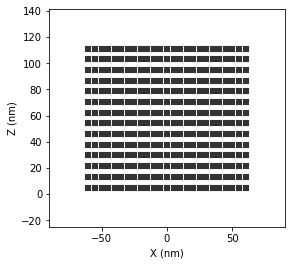

full:   N dp=1960


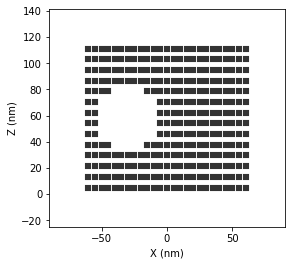

hole:   N dp=1960


/home/hans/.local/lib/python3.8/site-packages/numba/core/dispatcher.py:241: UserWarning: Numba extension module 'numba_scipy' failed to load due to 'VersionConflict((scipy 1.7.1 (/home/hans/.local/lib/python3.8/site-packages), Requirement.parse('scipy<=1.6.2,>=0.16')))'.
  entrypoints.init_all()


timing for wl=400.00nm - setup: EE 5843.2ms, inv.: 1307.5ms, repropa.: 4144.1ms (1 field configs), tot: 11295.0ms
timing for wl=405.00nm - setup: EE 160.2ms, inv.: 1303.3ms, repropa.: 53.7ms (1 field configs), tot: 1517.6ms
timing for wl=410.00nm - setup: EE 158.5ms, inv.: 1255.7ms, repropa.: 53.3ms (1 field configs), tot: 1467.9ms
timing for wl=415.00nm - setup: EE 193.0ms, inv.: 1387.1ms, repropa.: 55.0ms (1 field configs), tot: 1635.4ms
timing for wl=420.00nm - setup: EE 168.7ms, inv.: 1274.1ms, repropa.: 53.2ms (1 field configs), tot: 1496.1ms
timing for wl=425.00nm - setup: EE 163.6ms, inv.: 1309.5ms, repropa.: 54.8ms (1 field configs), tot: 1528.1ms
timing for wl=430.00nm - setup: EE 190.6ms, inv.: 1408.3ms, repropa.: 60.2ms (1 field configs), tot: 1659.3ms
timing for wl=435.00nm - setup: EE 189.7ms, inv.: 1367.7ms, repropa.: 53.5ms (1 field configs), tot: 1611.3ms
timing for wl=440.00nm - setup: EE 160.4ms, inv.: 1268.6ms, repropa.: 55.4ms (1 field configs), tot: 1484.6ms
timing

timing for wl=475.00nm - setup: EE 140.0ms, inv.: 1232.9ms, repropa.: 45.6ms (1 field configs), tot: 1418.7ms
timing for wl=480.00nm - setup: EE 149.3ms, inv.: 1128.3ms, repropa.: 49.6ms (1 field configs), tot: 1327.4ms
timing for wl=485.00nm - setup: EE 151.6ms, inv.: 1173.1ms, repropa.: 45.3ms (1 field configs), tot: 1370.3ms
timing for wl=490.00nm - setup: EE 139.4ms, inv.: 993.9ms, repropa.: 45.5ms (1 field configs), tot: 1179.0ms
timing for wl=495.00nm - setup: EE 124.5ms, inv.: 928.8ms, repropa.: 45.5ms (1 field configs), tot: 1099.2ms
timing for wl=500.00nm - setup: EE 129.5ms, inv.: 1084.0ms, repropa.: 47.1ms (1 field configs), tot: 1261.1ms
timing for wl=505.00nm - setup: EE 124.4ms, inv.: 1022.1ms, repropa.: 47.7ms (1 field configs), tot: 1194.5ms
timing for wl=510.00nm - setup: EE 129.2ms, inv.: 1180.2ms, repropa.: 45.7ms (1 field configs), tot: 1355.3ms
timing for wl=515.00nm - setup: EE 136.6ms, inv.: 961.1ms, repropa.: 48.1ms (1 field configs), tot: 1146.3ms
timing for wl

1

In [2]:
## --- simulation initialization ---

## --- geometry
mesh = 'hex'
step = 10         # in nm
radius = 60       # in nm
height = 120      # in nm
hole_radius = 25  # in nm


## --- Full nanodisc
geometry_0 = structures.nanodisc(step, R=radius/step, 
                                       H=height//step, mesh=mesh)
## --- Holed nanodisc
## We copy the full nanodisc meshpoints except where the hole is
X_h, _, Z_h = geometry_0.T
X_h = X_h - np.mean(X_h) + radius / 2.   # hole center = radius/2
Z_h = Z_h - np.mean(Z_h)
geometry_1 = geometry_0.copy()[X_h**2 + Z_h**2 > hole_radius**2]

material = materials.silicon()
struct_0 = structures.struct(step, geometry_0, material)
struct_1 = structures.struct(step, geometry_1, material)


## --- incident field: lin. pol plane wave
field_generator = fields.plane_wave
wavelengths = np.arange(400, 700, 5)
kwargs = dict(theta=0.0, inc_angle=180)   ## normal incidence from top
efield = fields.efield(field_generator,
                       wavelengths=wavelengths, kwargs=kwargs)


## --- environment
dyads = propagators.DyadsQuasistatic123(n1=1, n2=1)


## --- create simulation instance
sim_0 = core.simulation(struct_0, efield, dyads)
sim_1 = core.simulation(struct_1, efield, dyads)

visu.structure(sim_0, projection = 'XZ')
print("full:   N dp={}".format(len(geometry_0)))
visu.structure(sim_1, projection = 'XZ')
print("hole:   N dp={}".format(len(geometry_0)))

## --- run the main simulation ---
sim_0.scatter()
sim_1.scatter()


Extinction spectra
----------------------------------------------

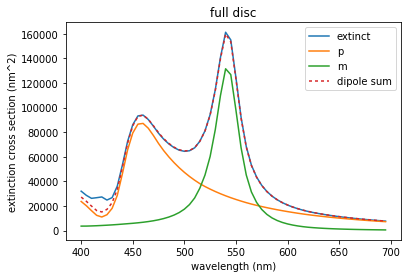

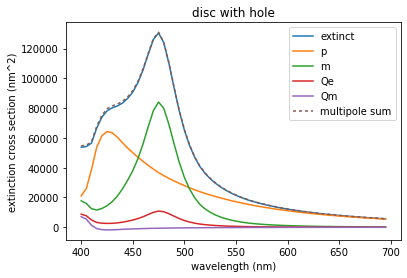

In [6]:
## -- spectra of extinction sections per multipole moment
wl, spec1 = tools.calculate_spectrum(sim_0, 0, linear.extinct)
ex_0, sc_0, ab_0 = spec1.T
wl, spec2 = tools.calculate_spectrum(sim_0, 0, multipole.extinct)
ex_p_0, ex_m_0, ex_qe_0, ex_qm_0 = spec2.T

plt.figure()
plt.title("full disc")
plt.plot(wl, ex_0, label='extinct')
plt.plot(wl, ex_p_0, label='p')
plt.plot(wl, ex_m_0, label='m')
plt.plot(wl, ex_p_0 + ex_m_0, label='dipole sum', dashes=[2,2])

plt.legend()
plt.xlabel("wavelength (nm)")
plt.ylabel("extinction cross section (nm^2)")
plt.show()



## -- spectra of extinction sections per multipole moment
wl, spec1 = tools.calculate_spectrum(sim_1, 0, linear.extinct)
ex_1, sc_1, ab_1 = spec1.T
wl, spec2 = tools.calculate_spectrum(sim_1, 0, multipole.extinct)
ex_p_1, ex_m_1, ex_qe_1, ex_qm_1 = spec2.T

plt.figure()
plt.title("disc with hole")
plt.plot(wl, ex_1, label='extinct')
plt.plot(wl, ex_p_1, label='p')
plt.plot(wl, ex_m_1, label='m')
plt.plot(wl, ex_qe_1, label='Qe')
plt.plot(wl, ex_qm_1, label='Qm')
plt.plot(wl, ex_p_1 + ex_m_1 + ex_qe_1 + ex_qm_1, label='multipole sum', dashes=[2,2])

plt.legend()
plt.xlabel("wavelength (nm)")
plt.ylabel("extinction cross section (nm^2)")
plt.show()

nearfield intensity across discs
------------------------------------------------------

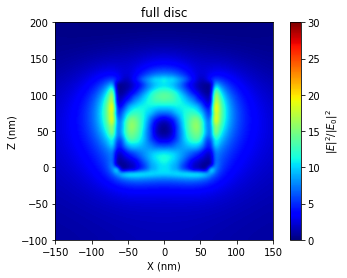

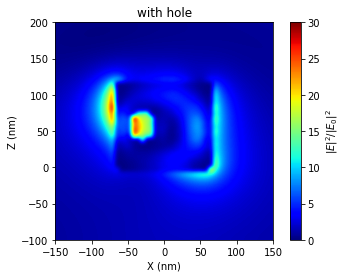

In [5]:
## -- nearfield intensity map: full disc
wl_0 = 540  # MD resonance
delta_wl = np.abs(wl - wl_0)
i_0 = np.argmin(delta_wl)
plt.figure()
MAP = tools.generate_NF_map_XZ(-150,150,51, -100,200,51, Y0 = 0)
Etot_0 = linear.nearfield(sim_0, field_index=i_0, r_probe=MAP, which_fields=['Et'])[0]
visu.vectorfield_color(Etot_0, cmap='jet', projection="XZ", 
                       fieldComp='I', clim=(0,30), tit='full disc', 
                       interpolation='bicubic', show=True)


## -- nearfield intensity map: with hole
wl_1 = 476  # MD resonance
delta_wl = np.abs(wl - wl_1)
i_1 = np.argmin(delta_wl)
plt.figure()
MAP = tools.generate_NF_map_XZ(-150,150,51, -100,200,51, Y0 = 0)
Etot_1 = linear.nearfield(sim_1, field_index=i_1, r_probe=MAP, which_fields=['Et'])[0]
visu.vectorfield_color(Etot_1, cmap='jet', projection="XZ", 
                       fieldComp='I', clim=(0,30), tit='with hole', 
                       interpolation='bicubic', show=True)